## Laboratory work No. 2
### Digital steganography by means of the least significant bit

In [467]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import wave

In [468]:
img = cv2.imread('InputImage.png', cv2.COLOR_BGR2RGB)
watermark = cv2.imread('WM.png', cv2.COLOR_BGR2RGB)

### Implementing a binary watermark

In [469]:
def embed_watermark(image, watermark, bits):
    if not (1 <= bits <= 8):
        raise ValueError("Кількість бітів має бути в межах 1-8")

    img_h, img_w, _ = image.shape

    if len(watermark.shape) == 3:
        watermark = cv2.cvtColor(watermark, cv2.COLOR_BGR2GRAY)

    wm_h, wm_w = watermark.shape
    _, wm = cv2.threshold(watermark, 127, 255, cv2.THRESH_BINARY)

    if wm_h < img_h or wm_w < img_w:
        wm = np.tile(wm, (img_h // wm_h + 1, img_w // wm_w + 1))
        wm = wm[:img_h, :img_w]

    if wm_h > img_h or wm_w > img_w:
        wm = wm[:img_h, :img_w]

    image_wm = image.copy()

    for i in range(img_h):
        for j in range(img_w):
            if wm[i, j] == 0:
                for b in range(bits):
                    bit_img = list(format(image_wm[i, j, 0], '08b'))
                    bit_img[7-b] = '1'
                    image_wm[i, j, 0] = int("".join(bit_img), 2)

    # Візуалізація результату
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Оригінальне зображення")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_wm, cv2.COLOR_BGR2RGB))
    plt.title("Зображення з водяним знаком")
    plt.axis("off")
    plt.show()

    return image_wm


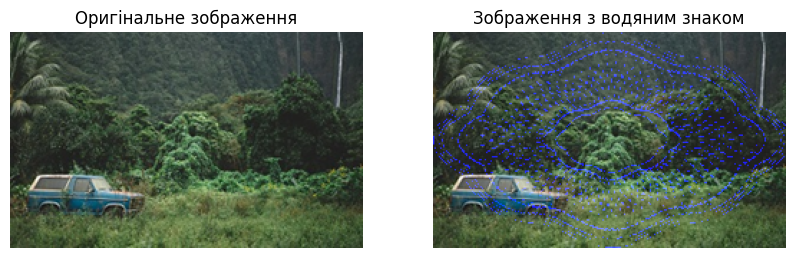

In [470]:
image_with_watermark = embed_watermark(img, watermark, 8)

### Extracting a binary watermark

In [471]:
def extract_watermark(image_wm, image):
    img_h, img_w, _ = image_wm.shape
    extracted_wm = np.zeros((img_h, img_w), dtype=np.uint8)

    for i in range(img_h):
        for j in range(img_w):
            bit_img = format(image[i, j, 0], '08b')
            bit_img_wm = format(image_wm[i, j, 0], '08b')

            if bit_img != bit_img_wm:
                extracted_wm[i, j] = 255

    _, extracted_wm = cv2.threshold(extracted_wm, 127, 255, cv2.THRESH_BINARY)

    # Візуалізація
    plt.imshow(extracted_wm, cmap='gray')
    plt.title("Extracted Watermark")
    plt.axis("off")
    plt.show()

    return extracted_wm


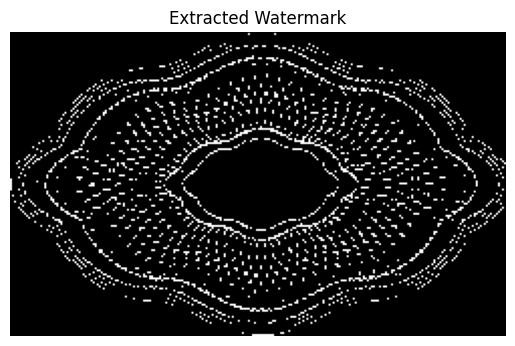

In [472]:
extracted_wm = extract_watermark(image_with_watermark, img)

### Implementing text

In [473]:
def embed_text(image, text):
    text = text + "\0"
    bin_text = ''.join(format(ord(c), '08b') for c in text)
    text_len = len(bin_text)

    img_h, img_w, _ = image.shape
    image_wm = image.copy()

    max_bits = img_h * img_w * 3
    if text_len > max_bits:
        raise ValueError(f"Текст занадто великий для цього зображення. Можна вбудувати лише {max_bits} бітів.")

    bin_index = 0

    for i in range(img_h):
        for j in range(img_w):
            if bin_index < text_len:
                pixel = image_wm[i, j]

                for k in range(3):
                    bit_img = format(pixel[k], '08b')
                    if bin_index < text_len:
                        bit_img = bit_img[:7] + bin_text[bin_index]
                        bin_index += 1
                    image_wm[i, j, k] = int(bit_img, 2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_wm, cv2.COLOR_BGR2RGB))
    plt.title("Image with Embedded Text")
    plt.axis("off")
    plt.show()

    return image_wm

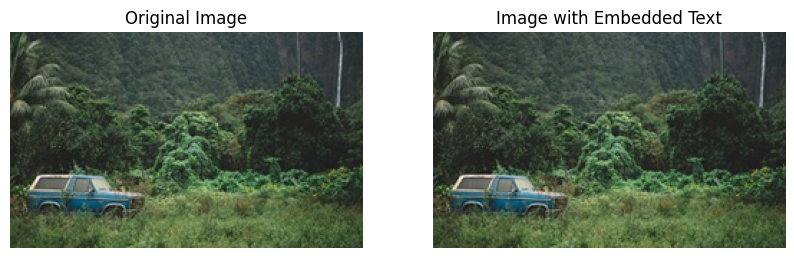

In [474]:
text = "I've been a puppet, a pauper, a pirate, a poet, A pawn and a king, I've been up and down and over and out, And I know one thing, Each time I find myself layin', Flat on my face, I just pick myself up and get Back in the race."
image_with_text = embed_text(img, text)

### Extracting text

In [475]:
def bin_to_text(bin_str):
    text = ""
    for i in range(0, len(bin_str), 8):
        byte = bin_str[i:i+8]
        text += chr(int(byte, 2))
    return text

In [476]:
def extract_text(image):
    img_h, img_w, _ = image.shape
    extracted_bin = ''

    for i in range(img_h):
        for j in range(img_w):
            pixel = image[i, j]

            for k in range(3):
                bit_img = format(pixel[k], '08b')
                extracted_bin += bit_img[-1]

    extracted_text = bin_to_text(extracted_bin)

    i = 0
    while extracted_text[i] != "\0":
        print(extracted_text[i], end="")
        i += 1
    return extracted_text

In [477]:
extracted_text = extract_text(image_with_text)

I've been a puppet, a pauper, a pirate, a poet, A pawn and a king, I've been up and down and over and out, And I know one thing, Each time I find myself layin', Flat on my face, I just pick myself up and get Back in the race.